## Стратегии распределения ресурсных блоков в централизованной сети со случайным графиком

Цель работы:

Получение навыков моделирования стандартных сценариев работы телекоммуникационных систем с топологией типа «звезда». Изучение свойств алгоритмов планирования ресурсов нисходящего кадра в подобных системах. Изучение стратегий распределения ресурсных блоков в централизованной сети со случайным трафиком

Параметры по варианту: <br>
* Модель распределения: **Окумура-Хата, small city**
* $R$, км: **1**
* $P_{TX}$, Вт: **10**
* $f_0$, МГц: **900**
* $k_n$: **2**
* $N_{RB}$: **25**

Используемые библиотеки

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy._typing import NDArray
from numpy import intp

### Основная теория


Из сети на БС поступают пакеты для передачи АБ. Объем каждого пакета равен $V_п = 1 \ кбайт$.

Каждому АБ внутри БС выделяется буфер. Задача БС - доставить пакеты каждому АБ, при этом буфер не должен переполняться </br>

Для этого время передачи разделено на равные интервалы - **слоты**, длительность которого равна $\tau_{RB} = 0.5 \ мс$.

Количество пакетов $P_i[k]$, поступивших в слоте $k$ для $i$-ого АБ: $ P_i[k] \sim Poison(\lambda)$.

Данные, поступившие на БС в слоте $k$, будут переданы АБ в слоте $k+1$.

Принято выделять 2 канала связи:
1. DownLink (DL, от БС к АБ)
2. UpLink (UL, от АБ к БС) </br>
![image.png](DL.png)

В данном случае полоса пропускания $\triangle f$ делится на равные интервалы $\triangle f_{RB} = 180 \ кГц$, образуя *ячейку* - **ресурсный блок**

Таким образом: столбцы - **слоты**, строки - **ресурные блоки**. При этом каждая ячейка таблицы имеет следующие размеры:
* $\triangle f_{RB} = 180 \ кГц$ (по высоте);
* $\tau_{RB} = 0.5 \ мс$ (по ширине).

Число внутри ячейки - номер пользователя, которому отдан ресурсный блок. Количество ресурсных блоков $N_{RB}$ определяет количество строк в матрице.

Объем данных, который **может** быть передан $i$-ому абоненту в $j$-ом ресурсном блоке $k$-ого слота: 
$$V_{i, j}[k] = C_{i, j}[k] \cdot \tau_{RB}$$ 
где $\tau_{RB} = 0.5 \ мс$.

Определяем основные константы:

In [83]:
# Параметры по варианту
R = 1                       # Радиус действия БС (км.)
P_tx = 10                   # Мощность излучения БС (Вт)
f_0 = 900                   # Частота излучения БС (МГц)
k_n = 2                     # Коэффициент теплового шума приёмника
N_rb = 25                   # Количество ресурсных блоков
slots = 10**2               # Количество слотов
h_bs = 30                   # Высота БС (м.)
h_rx = 2                    # Высота точки приёма (м.)
S = 0                       # Параметр, зависящий от типа среды (0/3)

# Константы
N = 2                         # Количество АБ
delta_f = 180 * 10**(3)       # Полоса пропуская канала связи БС (Гц)
T = 300                       # Абсолютная температура (К)
k = 1.38 * 10 ** (-23)        # Постоянная Больцмана (Дж/К)
tau = 5 * 10**(-4)            # Длительность одного слота (с.)
y = 1                         # Период расчета средней скорости (с.)
y_slot = int(np.ceil(y/tau))  # Количество слотов для расчета средней скорости
beta = 1/y_slot               # Параметр для сглаживания средней скорости


### Размещение N абонентов в радиусе R

Формулы для равномерного размещения абонентов в круге радиуса R. Используем полярные координаты:
$$ R = \sqrt{uniform(0, R^2, N)} $$
$$ angle = uniform(0, 2*\pi, N) $$

In [46]:
def create_abons(N: int, R: int, circle: bool = False):
    """Функция размещения абонентов внутри окружности с радиусом R

    Parameters
    ----------
    N : int
        Количество абонентов для генерации
    R : int
        Радиус охвата базовой станции, внутри которого необходимо 
        разместить абонентов
    circle : bool, optional
        Для вывода на график окружности и абонентов, by default False

    Returns
    -------
    Если circle задействован: 
        X: list
            Массив расположения абонентов по оси Х
        Y: list
            Массив расположения абонентов по оси Y
        X_R: list
            Массив точек окружности по оси X
        Y_R: list
            Массив точек окружности по оси Y
    Если circle не задействован:
        distance: list
            Массив расстояний от АБ до БС 
    """
    # Лямбда-функция создания расстояния от АБ до БС (по прямой)
    create_distance = lambda N: np.sqrt(np.random.uniform(0, R**2, N))
    distance = create_distance(N)
    if circle:
        create_angle = lambda N: np.random.uniform(0, 2 * np.pi, N)
        angle = create_angle(N)
        theta = np.linspace(0, 2 * np.pi, 100)
        # Для абонентов
        x, y = distance * np.cos(angle), distance * np.sin(angle)

        # Для окружности
        x_r, y_r = R * np.cos(theta), R * np.sin(theta)
        return x, y, x_r, y_r
    return distance

Для перехода к евклидовым координатам используем следующие преобразования:
$$ x = r * cos(angle) $$
$$ y = r * sin(angle) $$

Запустим данную функцию и визуализируем полученные результаты на графике:

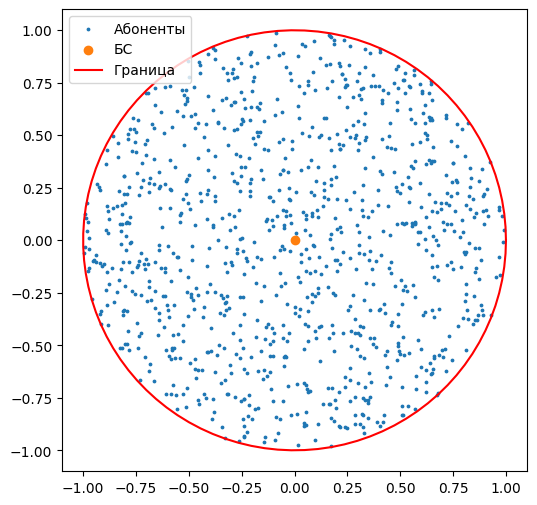

In [8]:
x, y, x_r, y_r = create_abons(1024, 1, True)

plt.figure(figsize=(6, 6))
plt.scatter(x, y, label="Абоненты", s=3)
plt.scatter(0, 0, label="БС")
plt.plot(x_r, y_r, label="Граница", color="r")
plt.legend()
plt.show()

### Генерация возможных скоростей передачи от БС к АБ

Объем данных, который **может** быть передан $i$-ому абоненту в $j$-ом ресурсном блоке $k$-ого слота: 
$$V_{i, j}[k] = C_{i, j}[k] \cdot \tau_{RB}$$ 
где $\tau_{RB} = 0.5 \ мс$.

$C_{i, j}[k]$ - максимальная пропускная способность у $i$-ого АБ в $j$-ом ресурсном блоке $k$-ого слота. Данное значение определяется по формуле: 
$$C_{i, j}[k] = \triangle f \log_2 (1 + SNR_{i, j}[k])$$ 

где $\triangle f = 180 \ кГц$. Из данной формулы необходимо найти $SNR_{i, j}[k]$. Данное значение вычисляется по формуле:
$$ SNR_{i, j}[k] = \frac{P_{i, j}[k]}{P_N} $$

где $$ P_N = \triangle f \cdot T \cdot k \cdot k_N $$ Формула для подсчета величины $P_{i, j}[k]$ выглядит следующим образом:
$$P_{i, j}[k] = \frac{P_{TX}}{L_{i, j}[k]}$$

Во всех вышеприведённых формулах известны следующие значения:
* $\triangle f = 180 \ (кГц)$ - полоса пропускания канала связи БС;
* $T = 300 \ (К)$ - абсолютная температура;
* $k = 1.38 \cdot 10^{-23} \ (Дж/К)$ - постоянная Больцмана;
* $k_n = 2$ - коэффициент теплового шума приёмника;
* $P_{TX} = 10 \ (Вт)$ - мощность излучения БС.

Для созданных расстояний до АБ необходимо найти степень затухания сигнала $L_{i, j}[k]$. Она определяется по формуле:
$$L_{i, j}[k] = L_i + x_{i, j}[k]$$
где $x_{i, j}[k] \sim Normal(\mu = 0, \sigma = 1)$ </br> $L_i$ - среднее затухание в канале от БС до $i$-ого АБ найденное при помощи модели Окамура-Хата. Формула выглядит следующим образом:
$$ 10 \lg L_i = 46.3 + 33.9\cdot\lg f_0 - 13.82\cdot\lg h_{БС} - \alpha(h_{RX}) + [44.9 - 6.55\cdot\lg h_{RX}]\lg d + S $$
В данной формуле изначально даны следующие параметры:
* $f_0 = 900 \ (МГц)$ - Частота сигнала; 
* $S = 0$ - параметр, зависящий от среды распространения сигнала (small city = 0, large city = 3);
* $h_{БС} = 30 \ (м)$ - высота БС;
* $h_{RX} = 2 \ (м)$ - высота точки приёма;


Величина $\alpha(h_{RX})$ высчитывается как:
$$ \alpha(h_{RX}) = (1.1 \cdot \lg f_0 - 0.7)h_{RX} - (1.56 \cdot \lg f_0 - 0.8) $$

In [47]:
def generate_subs(distance: list, slots_amount: int, tau: float) -> pd.DataFrame:
    """Функция генерации возможных скоростей для
    каждого абонента в каждом временном слоте

    Parameters
    ----------
    distance : list
        Массив созданных расстояний АБ
    slots_amount : int
        Количество слотов внутри сигнала передачи
    tau : float
        Время одного слота 

    Returns
    -------
    pd.DataFrame
        Датафрейм возможных пропускных способностей каналов каждого пользователя
    """
    # Подсчитываем величину a(h_rx)
    alpha_h_rx = (1.1 * np.log10(f_0) - 0.7) * h_rx - (1.56 * np.log10(f_0) - 0.8)

    # Потери мощности сигнала (lg(L))
    lg_l = (
        46.3
        + 33.9 * np.log10(f_0)
        - 13.82 * np.log10(h_bs)
        - alpha_h_rx
        + (44.9 - 6.55 * np.log10(h_rx)) * np.log10(distance)
        + S
    ) / 10

    # Потери мощности сигнала (L)
    L = 10 ** (lg_l)

    # Случайное затухание сигнала
    L = L + np.random.normal(loc=0, scale=1, size=len(L))

    # Принятая мощность сигнала (P_rx) (Вт)
    P_rx = P_tx / L

    # Мощность теплового шума (P_n) (Вт)
    P_n = delta_f * T * k * k_n

    # Соотношение сигнал/шум (SNR)
    SNR = P_rx / P_n

    # Максимальная пропускная способность канала (кбит/с)
    C = (delta_f * np.log2(1 + SNR)) / 8192

    # Создаём и заполняем датафрейм
    subs = pd.DataFrame(columns=range(slots_amount))
    for sub_i, C_i in enumerate(C):
        subs.loc[f"sub_{sub_i}"] = C_i * tau
    return subs

In [10]:
distances = create_abons(N, R)
subs = generate_subs(distances, N_rb, tau)
subs

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
sub_0,0.155663,0.155663,0.155663,0.155663,0.155663,0.155663,0.155663,0.155663,0.155663,0.155663,...,0.155663,0.155663,0.155663,0.155663,0.155663,0.155663,0.155663,0.155663,0.155663,0.155663
sub_1,0.184911,0.184911,0.184911,0.184911,0.184911,0.184911,0.184911,0.184911,0.184911,0.184911,...,0.184911,0.184911,0.184911,0.184911,0.184911,0.184911,0.184911,0.184911,0.184911,0.184911


### Формирование пуассоновской случайной величины

Для каждого абонента необходимо создать величину $ P_i[k] \sim Poison(\lambda)$, означающая количество пакетов объёма 1 кбайт, поступающих в буфер БС для $i$-ого АБ.

In [48]:
def generate_P(lambda_, subs) -> pd.DataFrame:
    """Функция генерации P_i - входного потока заявок
    на каждом слоте каждому абоненту

    Parameters
    ----------
    lambda_ : _type_
        Интенсивность пуассоновского распределения входных заявок
    subs : _type_
        Созданный датафрейм с возможными скоростями АБ

    Returns
    -------
    pd.DataFrame
        Датафрейм, показывающий количество заявок, пришедших пользователям по слотам
    """
    packs = pd.DataFrame(
        columns=subs.columns,
        data=[
            np.random.poisson(lambda_, len(subs.columns))
            for _ in range(len(subs.index))
        ]
    )
    return packs


generate_P(0.5, subs)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0,0,0,0,0,0,0,0,1,0,...,0,0,2,0,0,0,0,0,2,0
1,3,0,1,0,1,0,0,0,0,0,...,1,1,0,0,2,1,0,1,0,1


В данном датафрейме:
* Строки - номер абонента
* Столбцы - номер слота
* Ячейка - количество информационных пакетов

### Расчет значений приоритета пользователей

Существует 3 подхода к распределению ресурсов, основанных на алгоритмах, рассмотренных в предыдущей работе. Но перед тем, как начинать рассматривать данные методы, необходимо ввести некоторые определения:
* $\overline{R_i}[k]$ - средняя скорость загрузки данных $i$-ым АБ к $k$-ому слоту;
* $N_{RB}$ - количество ресурсных блоков;
* $r_i[k] = \displaystyle \sum_{j=1}^{N_{RB}} V_{i,j}[k]$ - объем данных переданных $i$-ому абоненту, если все ресурсы уйдут к $i$-ому;
* $p_{i,j}^{A}[k]$ - приоритет $i$-ого абонента на $j$-ый ресурсный блок в $k$-ом слоте

**Equal Blind**

Данный алгоритм приравнивает среднюю скорость загрузки. Приоритет пользователя определяется следующим образом:
$$p_{i,j}^{EB}[k] = \frac{1}{\overline{R_i}[k]}$$

Как и во всех последующих алгоритмах, ресурсный блок отдаётся тому пользователю, у которого наибольший приоритет: $i = \argmax{(p_{i,j}^{EB}[k])}$. Далее следует реализация данного метода в виде функции:

In [49]:
def priority_EB(subs_R_mean: list) -> NDArray[intp]:
    """Функция, возвращающая список приоритета пользователей
    по алгоритму ``Equal Blind``, выравнивающий скорость загрузки

    Parameters
    ----------
    subs_R_mean : list
        Массив средних скоростей пользователей

    Returns
    -------
    NDArray[intp]
        Рассчитанные приоритеты пользователей
    """
    # Расчет приоритетов и возвращение максимального
    subs_priority = [1 / R_i if R_i > 0 else 1 for R_i in subs_R_mean]

    # Получаем список отсортированных индексов АБ по приоритету
    subs_priority_ids = np.argsort(subs_priority)

    return subs_priority_ids

**Maximum Throughput**

Алгоритм "отдаёт" ресурсный блок тому пользователю, у которого максимальна пропускная способность канала связи:
$$p_{i,j}^{MT}[k] = C_{i, j}[k] $$

Далее следует реализация данного метода в виде функции:

In [50]:
def priority_MT(subs_chanel_capacity: list)-> NDArray[intp]:
    """Функция, возвращающая список приоритета пользователей
    по алгоритму ``Maximum Throughput``, отдающему все АБ с максимальной
    пропускной способностью

    Parameters
    ----------
    subs_chanel_capacity : list
        Массив возможных пропускных способностей АБ

    Returns
    -------
    NDArray[intp]
        Рассчитанные приоритеты пользователей
    """
    # Получаем список отсортированных индексов АБ по приоритету
    subs_priority_ids = np.argsort(subs_chanel_capacity)

    return subs_priority_ids

**Proportional Fair**

Алгоритм выравнивания ресурсов, отдаваемых пользователям. Приоритет $i$-ого пользователя на ресурсный блок определяется как:
$$ p_{i,j}^{PF}[k] = \frac{C_{i, j}[k]}{\overline{R_i}[k]} $$

Далее следует реализация данного метода в виде функции:

In [51]:
def priority_PF(subs_chanel_capacity: list, subs_R_mean: list)-> NDArray[intp]:
    """Функция, возвращающая список приоритета пользователей
    по алгоритму ``Proportional Fair``, выравнивающего ресурсы между АБ

    Parameters
    ----------
    subs_chanel_capacity : list
        Массив возможных пропускных способностей АБ
    subs_R_mean : list
        Массив средних скоростей пользователей

    Returns
    -------
    NDArray[intp]
        Рассчитанные приоритеты пользователей
    """
    # Расчет приоритетов и возвращение максимального
    subs_priority = [C_i / (R_i if R_i > 0 else 1) for C_i, R_i in zip(subs_chanel_capacity, subs_R_mean)]

    # Получаем список отсортированных индексов АБ по приоритету
    subs_priority_ids = np.argsort(subs_priority)

    return subs_priority_ids

Далее, для того, чтобы определить, какой алгоритм требуется, необходимо определить дополнительную функцию, в которой можно будет выбирать алгоритм распределения ресурсов:

In [15]:
def calc_priority(alg: str, R_mean: list, chanel_capacity: list)-> NDArray[intp]:
    """Функция выбора алгоритма расчета приоритета АБ. Выбор метода осуществляется
    при помощи переменной ``alg``, которая может принимать значения:
    * ``EB`` - расчет приоритета будет производится по методу Equal Blind;
    * ``MT`` - расчет приоритета будет производится по методу Maximal Throughput;
    * ``PF``- расчет приоритета будет производится по методу Proportional Fair.

    Parameters
    ----------
    alg : str
        Тип алгоритма, по которому рассчитывается приоритет АБ
    R_mean : list
        Массив средних скоростей пользователей
    chanel_capacity : list
        Массив возможных пропускных способностей АБ

    Returns
    -------
    NDArray[intp]
        Рассчитанные приоритеты пользователей
    """
    match alg:
        case "EB":
            return priority_EB(R_mean)
        case "MT":
            return priority_MT(chanel_capacity)
        case "PF":
            return priority_PF(chanel_capacity, R_mean)
    raise ValueError(f"Для значения {alg = } не существует алгоритма работы")

### Расчет средней скорости загрузки

В двух из трёх рассмотренных способов используется значение средней скорости загрузки $i$-ым АБ к $k$-ому слоту. Существует 2 основных способа расчета данного значения:

**Первый способ**

Фиксируется интервал времени $y$ на котором рассчитывается средняя скорость. Определяем количество слотов:
$$ y_{слот} = \left \lceil \frac{y}{\tau_{RB}} \right \rceil $$

Средняя скорость, с которой абонент загружал данные может быть рассчитана как:
$$\overline{R_i}[k] = \frac{\displaystyle \sum_{m=k-1-y}^{k-1} \left [\sum_{j=1}^{N_{RB}} V_{i,j}[m] \cdot b_{i,j} [m] \right]}{y \ или \ y_{слот}}$$

В данной формуле сумма $ \displaystyle \sum_{j=1}^{N_{RB}} V_{i,j}[m] \cdot b_{i,j} [m]$ - показывает объем данных, переданный $i$-ому АБ в $k$-ом слоте.

Далее следует реализация данного метода в виде функции:

In [53]:
def calc_R_mean(slot_id: int, sub_id: int, resources: list, subs: pd.DataFrame) -> float:
    """Функция, рассчитывающая среднюю скорость загрузки данных i-ого АБ 
    по первому алгоритму

    Parameters
    ----------
    slot_id : int
        Номер слота, для которого рассчитывается среднее значение
    sub_id : int
        Номер пользователя, для которого рассчитывается среднее значение
    resources : list
        Массив ресурсов, которые были использованы в предыдущих слотах
    subs : pd.DataFrame
        Созданный датафрейм с возможными скоростями АБ

    Returns
    -------
    float
        Рассчитанная средняя скорость загрузки данных
    """
    # Объём данных, который передан абоненту sub_id
    packs_sum = 0
    result = .0

    # Цикл по слотам:
    for slot_i in range(max(0, slot_id - 1 - y_slot), slot_id):

        # Кол-во ресурсных блоков в слоте slot_id, которые пренадлежат АБ с индексом sub_id
        resource_blocks = 0

        # Цикл по ресурсным блокам
        for res_sub_i in resources[slot_i]:
            # Проверка принадлежности ресурсного блока в слоте АБ sub_idx
            if res_sub_i == sub_id:
                resource_blocks += 1

        # Находим объём данных, который передан абоненту sub_idx в ресурсных блоках в слоте slot_idx
        packs_sum += subs.iloc[slot_i, sub_id] * resource_blocks
        result = packs_sum / y_slot
    return result

**Второй способ**

Второй способ - сглаживающий фильтр - заключается в том, что средняя скорость, с которой абонент загружал, может быть записана как:
$$\overline{R_i}[k] = (1-\beta) \cdot \overline{R_i}[k-1] + \beta \cdot \frac{\displaystyle \sum_{j=1}^{N_{RB}} V_{i,j}[k-1] \cdot b_{i,j} [k-1]}{\tau_{RB}}$$
где $\beta = \frac{1}{y_{слот}}$

Далее следует реализация данного метода в виде функции:

In [76]:
def calc_smooth_R_mean(slot_id: int, sub_id: int, resources: list, subs: pd.DataFrame, R_mean_list: list) -> float:
    """Функция, рассчитывающая среднюю скорость загрузки данных i-ого АБ
    методом сглаживающего фильтра

    Parameters
    ----------
    slot_id : int
        Номер слота, для которого рассчитывается среднее значение
    sub_id : int
        Номер пользователя, для которого рассчитывается среднее значение
    resources : list
        Массив ресурсов, которые были использованы в предыдущих слотах
    subs : pd.DataFrame
        Созданный датафрейм с возможными скоростями АБ 
    R_mean_list : list
        Средние скорости АБ, рассчитанные до этого

    Returns
    -------
    float
        Рассчитанная средняя скорость загрузки данных
    """
    # Расчет результата
    result = (1-beta) * R_mean_list[sub_id] + beta * (np.sum([subs.iloc[sub_id, slot_id] for res_id in resources[-1] if res_id == sub_id]) / tau)
    return result

### Расчет среднего суммарного объема данных

Для сравнения между собой приведённых выше алгоритмов распределения ресурсов, необходимо ввести переменную $D_i[k]$ - объем данных, находящихся в буфере $i$-ого абонента на конец $k$-ого слота. Для определения объема используется следующее выражение:
$$ D_i[k] = D_i[k-1] - \displaystyle \sum_{j=1}^{N_{RB}} V_{i,j}[k] \cdot b_{i,j} [k] + P_i[k] * 1 \ кбайт$$

Для оценки эффективности рассмотренных алгоритмов необходимо построить график зависимости $D_i[k]$ (средний суммарный объем буфера) от $\lambda$ (параметр распределения входящего потока заявок) при различном количестве абонентов в БС.

Далее следует реализация данного метода в виде функции:

In [77]:
def calc_D_mean(subs: pd.DataFrame, lambda_: float, algorithm: str) -> float:
    """Функция, рассчитывающая среднее суммарное значение объема буфера
    в зависимости от: 
    * количества пользователей;
    * интенсивности прихода заявок;
    * типа алгоритма распределения ресурсов.

    Parameters
    ----------
    subs : pd.DataFrame
        Созданный датафрейм с возможными скоростями АБ 
    lambda_ : float
        Интенсивность пуассоновского распределения входных заявок
    algorithm : str
        Тип алгоритма, по которому происходит приоритизация АБ в системе

    Returns
    -------
    float
        Рассчитанное среднее суммарное значение объема буфера
    """
    # Генерация входящего потока пакетов
    P = generate_P(lambda_, subs)

    # Отправляем в буфер первый слот
    buffer = [P[0].to_list()]

    # Массив ресурсных блоков слотов
    resources = [[]]

    # Список средних скоростей (в начале 0.0 у всех)
    R_mean_list = [[calc_R_mean(0, sub_id, resources, subs) for sub_id in range(len(subs.index))]]

    # ID рассматриваемого пользователя
    current_sub_id = 0
    R_buffered_subs = []

    # Цикл по слотам
    for slot_id in range(1, len(P.columns)):
        # Рассчитываем среднюю скорость только для EB и PF
        if algorithm in ["EB", "PF"]:
            # R_mean_list.append(
                # [calc_R_mean(slot_id, sub_id, resources, subs) for sub_id in range(len(subs.index))]
            # )
            R_mean_list.append(
                [calc_smooth_R_mean(slot_id, sub_id, resources, subs, R_mean_list[-1]) for sub_id in range(len(subs.index))]
            )

        # Ищем пользователей с заполненным буфером
        subs_with_buffer = [i % len(subs.index) for i in range(current_sub_id, current_sub_id + len(subs.index)) if buffer[-1][i % len(subs.index)] != 0]
        current_sub_id = (current_sub_id + 1) % len(subs.index)

        # Расчет нового буфера для текущего слота
        buffer.append(buffer[-1].copy())

        # Если есть АБ с заполненным буфером
        if subs_with_buffer:
            # Выбираем параметры АБ из списка
            R_buffered_subs = []
            C_buffered_subs = []
            for i in subs_with_buffer:
                R_buffered_subs.append(R_mean_list[-1][i])
                C_buffered_subs.append(subs.iloc[i, slot_id])

            # Создаём список приоритета АБ
            priority_list = calc_priority(algorithm, R_buffered_subs, C_buffered_subs)
            subs_priority = [sub for _, sub in sorted(zip(priority_list, subs_with_buffer))]

            # Сколько ресурсов нужно каждому АБ
            slots_res_block = [int(np.ceil(buffer[-1][sub_id] / subs.iloc[sub_id, slot_id])) for sub_id in subs_priority]
            if np.sum(slots_res_block) > N_rb:
                cut_off = np.sum(slots_res_block) - N_rb
                slots_res_block[-1] -= cut_off
                while slots_res_block[-1] <= 0:
                    cut_off = slots_res_block.pop()
                    slots_res_block[-1] += cut_off

            resources.append(slots_res_block)
            # Удаляем АБ, без ресурсов в слоте
            if len(slots_res_block) != len(subs_priority):
                difference = len(slots_res_block) - len(subs_priority)
                subs_priority = subs_priority[:difference]

            # Обработка АБ с выделенными ресурсами (уменьшаем буфер АБ)
            for id, sub_id in enumerate(subs_priority):
                buffer[-1][sub_id] = max(0, buffer[-1][sub_id] - subs.iloc[sub_id, slot_id] * slots_res_block[id])
        # Если нет АБ с заполненным буфером
        else:
            resources.append([])
        
        # Добавляем новые пакеты
        buffer[-1] = [buff + pack for buff, pack in zip(buffer[-1], P[slot_id])]
    
    # Расчет среднего суммарного объема буфера по слотам
    return np.mean([sum(slot_buff) for slot_buff in buffer])

### Построение графиков

В качестве результата выполнения данной лабораторной работы необходимо построить графики зависимости среднего суммарного объема данных $D_i[k]$ от параметра пуассоновского распределения $\lambda$ при разном количестве АБ в соте.

Для этого создадим функцию:

In [92]:
def plot_dependencies(l_start: int, l_stop: int, subs_count: int) -> None:
    """Функция создания графика зависимости среднего суммарного объема данных
    от интенсивности распределения входного потока заявок.

    Parameters
    ----------
    l_start : int >= 0
        Минимальное значение интенсивности входного потока заявок
    l_stop : int >= l_start
        Максимальное значение интенсивности входного потока заявок
    subs_count : int
        Количество абонентов в зоне действия базовой станции
    """
    # Генерация: параметра лямбда, расположений и возможных скоростей
    lambdas = np.linspace(l_start, l_stop, 11)
    distances = create_abons(subs_count, R)
    subs = generate_subs(distances, slots, tau)

    # Цикл по алгоритмам
    for alg in ["EB", "MT", "PF"]:
        D_score = []
        for l in lambdas:
            D_score.append(calc_D_mean(subs, l, alg))
            # print(f'{alg = }, {l = :.2f}, {D_score[-1] = :.3f}')
        
        # Добавляем линию на график
        plt.plot(lambdas, D_score, marker='.', label=f'{alg}, {subs_count}')    

Далее рассмотрим результаты моделирования при разном количестве абонентов:

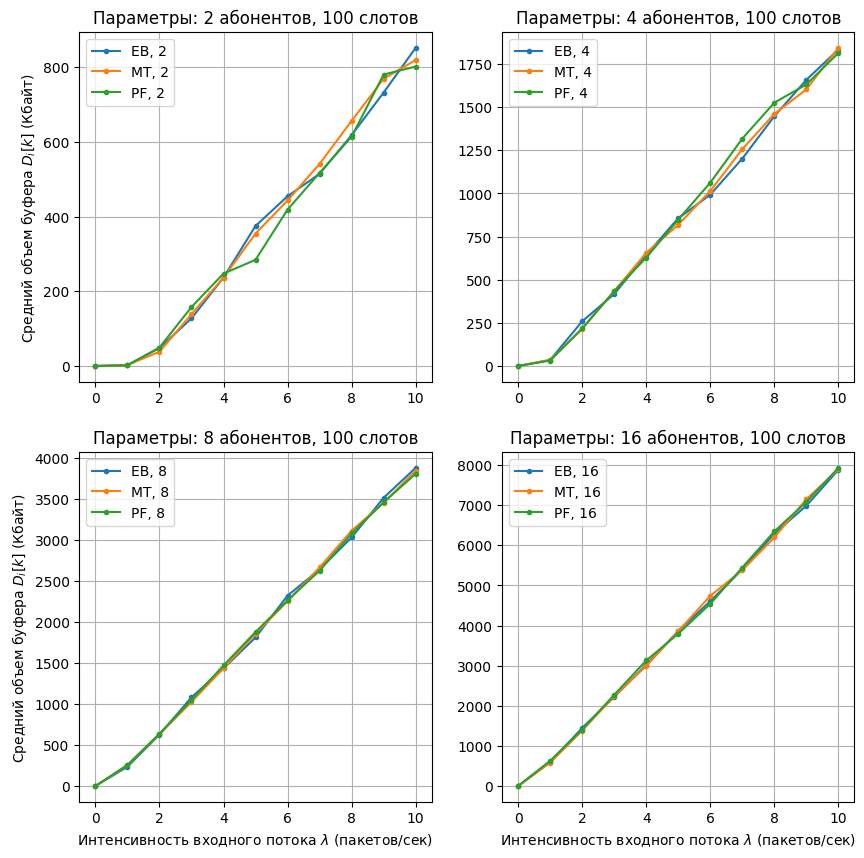

In [98]:
plt.figure(figsize=(10, 10))
for i, N in enumerate([2, 4, 8, 16]):
    plt.subplot(2, 2, i+1)
    plot_dependencies(0, 10, N)
    plt.title(f'Параметры: {N} абонентов, {slots} слотов')
    plt.legend()
    plt.grid()
    if i+1 in [1, 3]:
        plt.ylabel(r'Средний объем буфера $D_i[k]$ (Кбайт)')
    if i+1 in [3, 4]:
        plt.xlabel(r'Интенсивность входного потока $\lambda$ (пакетов/сек)')

Исследовав полученные графики, можно сделать несколько выводов. Во-первых, отчетливо можно заметить пороговое значение интенсивности входного потока заявок, при котором объем буфера начинает стремительно расти, а также видна закономерности данного порогового значения от количества абонентов в системе. Так, например, резкий рост объема данных в буфере при 2-ух абонентах в системе начинается при интенсивности входного потока $\lambda > 2$, а при 8-ми абонентах $\lambda > 1$. Таким образом, можно сказать, что происходит "выпрямление" графика зависимости объема буфера от интенсивности входного потока при увеличении количества абонентов.

Во-вторых, при исследовав отличия между алгоритмами распределения ресурсов, можно заметить что наиболее устойчивым алгоритмом является - Maximum Throughput. Его устойчивость хорошо показана при 2-ух абонентах и заключается в том, что график данного метода растёт увереннее и прямолинейнее остальных. Подобная отличительная особенность сохраняется и на последующих графиках, однако там она не сильно выделяется, поскольку остальные методы также принимают прямолинейный характер графика. Также, складывается такое впечатление, что график алгоритма Maximum Throughput является пределом, к которому стремятся графики остальных алгоритмов.

В итоге, созданные графики позволяют оценить оптимальное количество абонентов для созданной математической модели в зависимости от интенсивности входного потока сообщений.

### Выводы

В ходе выполнения данной лабораторной работы мною были получены навыки моделирования стандартных сценариев работы телекоммуникационных систем с топологией типа «звезда», изучены свойства алгоритмов планирования ресурсов нисходящего кадра в подобных системах, а также изучены стратегий распределения ресурсных блоков в централизованной сети со случайным трафиком.

В процессе выполнения работы, была создана модель базовой станции, в которой время передачи информации абонентам было разбито на отдельные слоты, а у самой базовой станции было конечное количество ресурсов для передачи. Благодаря созданной модели удалось собрать данные об суммарном объёме буфера системы (для всех пользователей) при различных значениях интенсивности потока входящих пакетов. Усреднив суммарный объем по количеству слотов в системе, был получен массив чисел, по которому и строились итоговые визуализации данных. 

Итоговая визуализации данных представляла из себя график зависимости среднего суммарного объема данных, находящихся в буфере, от параметра интенсивности потока входящих информационных пакетов для трёх рассматриваемых алгоритмов распределения ресурсов: Maximum Throughput, Equal Blinds и Proportional Fair при различном количестве абонентов внутри базовой станции.

Из полученных графиков было сделано несколько выводов. Первое и самое очевидное - при увеличении количества пользователей в системе средний объем растёт очень быстро при увеличении интенсивности входного потока пакетов, вне зависимости от алгоритма распределения ресурсов. Второй полученный вывод звучит следующим образом: при увеличении количества абонентов вокруг базовой станции, уменьшается пороговое значение интенсивности входного потока заявок, после которого начинается стремительный рост объема буфера. Кроме этого, визуальный анализ полученных графиков показал, что алгоритм Maximum Throughput ненамного превосходит остальные алгоритмы. Данное превосходство объясняется тем, что алгоритм выбирает абонента с наибольшей пропускной способностью, что позволяет передавать больший объем информации при сравнении с другими алгоритмами. Equal Binds и Proportional Fair в свою очередь распределяют ресурсы между абонентами равномерно (первый выравнивает среднюю скорость приёма данных, второй выравнивает отношение пропускной способности к средней скорости приёма данных), в связи с чем средний переданный объем информации в данных вариантах оказывается ниже.